In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'Data')
# print(data_dir)

In [3]:
# read the model info, including the model name, the number of parameters, and the number of MACs
# read the model training info, including the training time, each layer's training time, the epoch time and the epoch energy data
data_model_dir = os.path.join(data_dir, 'model_info')
# read all the model info csv files
model_info_files = os.listdir(data_model_dir)
cifar100_dataset = pd.read_csv(os.path.join(data_model_dir, 'cifar100_datasetinfo.csv'))
fashionmnist_modelinfo = pd.read_csv(os.path.join(data_model_dir, 'fashionmnist_datasetinfo.csv'))

In [4]:
print(cifar100_dataset.head(),'\n',
      '*'*50, '\n',
      fashionmnist_modelinfo.head())

      Model          MACs   Parameters  TotalEnergyPerEpoch  \
0   Alexnet  7.123900e+08   57040000.0              2985.59   
1     VGG11  7.640000e+09  129180000.0             23860.35   
2     VGG13  1.135000e+10  129360000.0             37894.64   
3     VGG16  1.552000e+10  134670000.0             46992.02   
4  ResNet18  1.830000e+09   11230000.0              9525.80   

   AverageEnergyPerSec  TotalTime  AverageTimeperEpoch  Total Time to Device  \
0               135.45     431.56                21.58                100.94   
1               294.21    1618.57                80.93                114.94   
2               326.68    2317.64               115.88                117.14   
3               340.52    2749.50               137.48                115.99   
4               210.37     897.24                44.86                114.59   

   Average Time to Device  Total Forward Time  Average Forward Time  \
0                    5.05               36.81                  1.84  

In [5]:
# seperate the vgg model data with others
vgg_data_f = fashionmnist_modelinfo[fashionmnist_modelinfo['Model'].str.contains('VGG')]
vgg_data_c = cifar100_dataset[cifar100_dataset['Model'].str.contains('VGG')]

# remove the vgg model data from the original data
model_data_f = fashionmnist_modelinfo[~fashionmnist_modelinfo['Model'].str.contains('VGG')]
model_data_c = cifar100_dataset[~cifar100_dataset['Model'].str.contains('VGG')]

In [6]:
vgg_data_f

,Model,MACs,Parameters,TotalEnergyPerEpoch,AverageEnergyPerSec,TotalTime,AverageTimeperEpoch,Total Time to Device,Average Time to Device,Total Forward Time,Average Forward Time,Total Backward Time,Average Backward Time,Total Test Time,Average Test Time
1,VGG11,7.580000e+09,128810000.0,27264.35,324.59,1667.45,83.37,47.60,2.38,477.64,23.88,939.96,47.00,110.53,5.53
2,VGG13,1.130000e+10,128990000.0,43858.97,350.60,2494.23,124.71,47.43,2.37,732.13,36.61,1468.48,73.42,152.73,7.64
3,VGG16,1.546000e+10,134300000.0,54043.96,360.06,2987.17,149.36,47.13,2.36,890.96,44.55,1778.02,88.90,179.09,8.95


In [7]:
model_data_f

,Model,MACs,Parameters,TotalEnergyPerEpoch,AverageEnergyPerSec,TotalTime,AverageTimeperEpoch,Total Time to Device,Average Time to Device,Total Forward Time,Average Forward Time,Total Backward Time,Average Backward Time,Total Test Time,Average Test Time
0,Alexnet,6.655300e+08,57030000.0,2627.00,184.48,277.36,13.87,41.25,2.06,41.13,2.06,71.34,3.57,48.18,2.41
4,ResNet18,1.750000e+09,11180000.0,10202.03,256.70,786.20,39.31,46.92,2.35,188.77,9.44,394.64,19.73,61.88,3.09
5,ResNet34,3.600000e+09,21290000.0,17610.77,292.56,1199.54,59.98,48.64,2.43,308.04,15.40,670.02,33.50,76.78,3.84
6,ResNet50,2.320000e+09,13870000.0,14077.76,256.90,1087.51,54.38,47.15,2.36,285.08,14.25,595.25,29.76,71.50,3.57
7,GoogleNet,1.520000e+09,5980000.0,11261.41,269.49,828.63,41.43,52.71,2.64,197.74,9.89,406.06,20.30,66.32,3.32
8,GoogleNet_mod0,4.069300e+08,120070.0,3939.60,198.72,389.09,19.45,53.94,2.70,71.54,3.58,124.57,6.23,55.31,2.77
9,GoogleNet_mod1,1.090000e+09,3420000.0,6870.30,237.80,569.88,28.49,59.67,2.98,125.87,6.29,232.45,11.62,59.26,2.96
10,GoogleNet_mod2,1.870000e+09,7280000.0,10452.89,267.77,774.12,38.71,64.65,3.23,181.73,9.09,367.34,18.37,63.09,3.15
11,GoogleNet_mod3,2.740000e+09,11710000.0,14497.42,289.67,993.21,49.66,58.48,2.92,240.75,12.04,524.69,26.23,72.91,3.65
12,GoogleNet_mod4,3.710000e+09,16700000.0,19205.71,297.54,1284.65,64.23,71.08,3.55,308.98,15.45,709.19,35.46,86.99,4.35


In [8]:
# change the ResNet50 model name to ResNet_test
model_data_f['Model'] = model_data_f['Model'].str.replace('ResNet50', 'ResNet_test')
model_data_c['Model'] = model_data_c['Model'].str.replace('ResNet50', 'ResNet_test')

/var/folders/z9/ym3y50cd7q7gfczkkgdfrbp00000gn/T/ipykernel_85054/1807416289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_f['Model'] = model_data_f['Model'].str.replace('ResNet50', 'ResNet_test')
/var/folders/z9/ym3y50cd7q7gfczkkgdfrbp00000gn/T/ipykernel_85054/1807416289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_c['Model'] = model_data_c['Model'].str.replace('ResNet50', 'ResNet_test')


In [9]:
model_data_f

,Model,MACs,Parameters,TotalEnergyPerEpoch,AverageEnergyPerSec,TotalTime,AverageTimeperEpoch,Total Time to Device,Average Time to Device,Total Forward Time,Average Forward Time,Total Backward Time,Average Backward Time,Total Test Time,Average Test Time
0,Alexnet,6.655300e+08,57030000.0,2627.00,184.48,277.36,13.87,41.25,2.06,41.13,2.06,71.34,3.57,48.18,2.41
4,ResNet18,1.750000e+09,11180000.0,10202.03,256.70,786.20,39.31,46.92,2.35,188.77,9.44,394.64,19.73,61.88,3.09
5,ResNet34,3.600000e+09,21290000.0,17610.77,292.56,1199.54,59.98,48.64,2.43,308.04,15.40,670.02,33.50,76.78,3.84
6,ResNet_test,2.320000e+09,13870000.0,14077.76,256.90,1087.51,54.38,47.15,2.36,285.08,14.25,595.25,29.76,71.50,3.57
7,GoogleNet,1.520000e+09,5980000.0,11261.41,269.49,828.63,41.43,52.71,2.64,197.74,9.89,406.06,20.30,66.32,3.32
8,GoogleNet_mod0,4.069300e+08,120070.0,3939.60,198.72,389.09,19.45,53.94,2.70,71.54,3.58,124.57,6.23,55.31,2.77
9,GoogleNet_mod1,1.090000e+09,3420000.0,6870.30,237.80,569.88,28.49,59.67,2.98,125.87,6.29,232.45,11.62,59.26,2.96
10,GoogleNet_mod2,1.870000e+09,7280000.0,10452.89,267.77,774.12,38.71,64.65,3.23,181.73,9.09,367.34,18.37,63.09,3.15
11,GoogleNet_mod3,2.740000e+09,11710000.0,14497.42,289.67,993.21,49.66,58.48,2.92,240.75,12.04,524.69,26.23,72.91,3.65
12,GoogleNet_mod4,3.710000e+09,16700000.0,19205.71,297.54,1284.65,64.23,71.08,3.55,308.98,15.45,709.19,35.46,86.99,4.35


In [10]:
# find out the MACs of each model
macs_train_f = model_data_f['MACs'].values.reshape(-1, 1)
macs_test_f = vgg_data_f['MACs'].values.reshape(-1, 1)
macs_train_c = model_data_c['MACs'].values.reshape(-1, 1)
macs_test_c = vgg_data_c['MACs'].values.reshape(-1, 1)
# find out the energy of each model
energy_train_f = model_data_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_f = vgg_data_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_train_c = model_data_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_c = vgg_data_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)

# print(macs_train_f,'\n','*'*50,'\n',macs_test_f)
# print('*'*50)
# print(energy_train_f, '\n','*'*50,'\n', energy_test_f)

In [11]:
model_onlymacs_f = LinearRegression()
model_onlymacs_f.fit(macs_train_f, energy_train_f)
vgg_pred_f = model_onlymacs_f.predict(macs_test_f)
r2_f = model_onlymacs_f.score(macs_test_f, energy_test_f)

print(f'The predict values are: {vgg_pred_f}')
print('*'*50)
print(f'The actual values are: {energy_test_f}')
print('*'*50)
print(f'The R2 score is: {r2_f}')

The predict values are: [[36213.82118763]
 [52649.53717404]
 [71029.26257819]]
**************************************************
The actual values are: [[27264.35]
 [43858.97]
 [54043.96]]
**************************************************
The R2 score is: -0.2201478059995532


In [12]:
model_onlymacs_c = LinearRegression()
model_onlymacs_c.fit(macs_train_c, energy_train_c)
vgg_pred_c = model_onlymacs_c.predict(macs_test_c)
r2_c = model_onlymacs_c.score(macs_test_c, energy_test_c)

print(f'The predict values are: {vgg_pred_c}')
print('*'*50)
print(f'The actual values are: {energy_test_c}')
print('*'*50)
print(f'The R2 score is: {r2_c}')

The predict values are: [[31397.19383028]
 [45223.54836743]
 [60764.22179598]]
**************************************************
The actual values are: [[23860.35]
 [37894.64]
 [46992.02]]
**************************************************
The R2 score is: -0.10526978861944292


In [13]:
def PlotMACs_vs_Energy(df, macs_test, energy_pred, energy_test, model_name):
    # first plot the MACs vs Energy of the training data, and then plot the MACs vs Energy of the test data and the predicted data in the same plot
    # set the prediction data as green, the test data as red, and the training data as blue
    # the predicted data is the linear regression model's prediction, and use the dot to represent the data
    extended_x_min = min(df['MACs'].min(), macs_test.min()) * 0.8  # slightly more than minimum
    extended_x_max = max(df['MACs'].max(), macs_test.max()) * 1.2  # slightly more than maximum

    # Generate extended x values
    extended_x = np.linspace(extended_x_min, extended_x_max, 100)  # generate 100 points for a smooth line
    plt.figure(figsize=(10, 6))
    plt.scatter(df['MACs'], df['TotalEnergyPerEpoch'], color='blue', label='Training Data')
    plt.scatter(macs_test, energy_test, color='red', label='Test Data')
    plt.scatter(macs_test, energy_pred, color='green', label='Predicted Data')
    # plot the predict line, with the model coefficient and intercept, plot it as green and extend the line
    model_coef = model_name.coef_
    model_intercept = model_name.intercept_
    extended_y = model_coef * extended_x + model_intercept
    plt.plot(extended_x, extended_y.reshape(-1,1), color='green', label='Regression Line')
    plt.xlabel('MACs')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
    

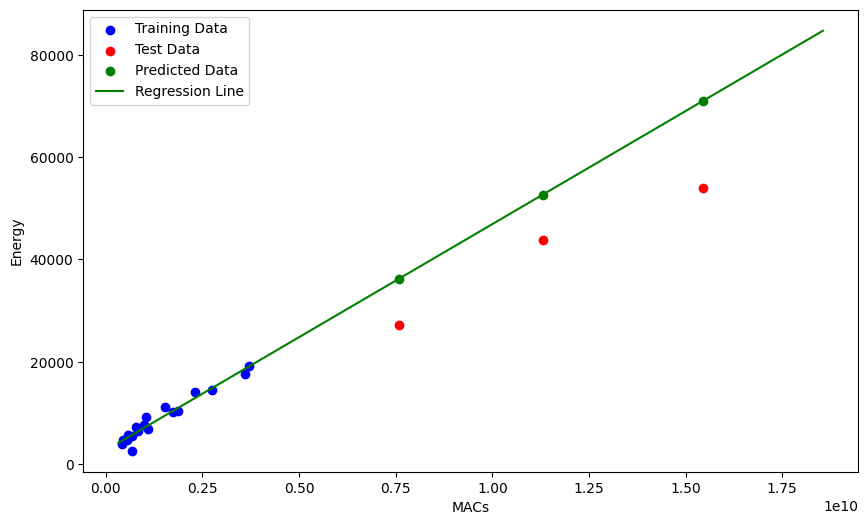

In [14]:
PlotMACs_vs_Energy(model_data_f, macs_test_f, vgg_pred_f, energy_test_f, model_onlymacs_f)

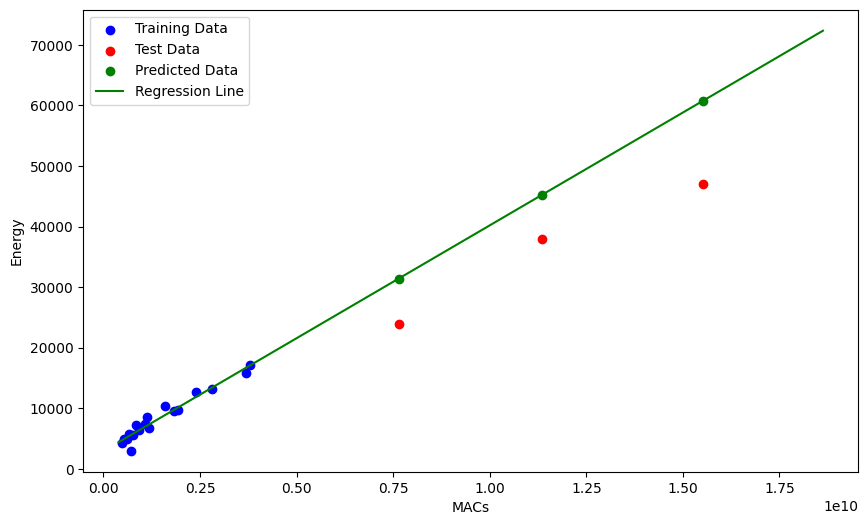

In [15]:
PlotMACs_vs_Energy(model_data_c, 
                    macs_test_c, 
                     vgg_pred_c, 
                  energy_test_c,
                  model_onlymacs_c)

### create a new ml model with more input dimension  
the train value include vgg11, let the test value is vgg16 only

In [16]:
# seperate the vgg model data with others
testdata_only16_f = fashionmnist_modelinfo[fashionmnist_modelinfo['Model'].str.contains('VGG16')]
testdata_only16_c = cifar100_dataset[cifar100_dataset['Model'].str.contains('VGG16')]

# remove the vgg model data from the original data
modeldata_only16_f = fashionmnist_modelinfo[~fashionmnist_modelinfo['Model'].str.contains('VGG16')]
modeldata_only16_c = cifar100_dataset[~cifar100_dataset['Model'].str.contains('VGG16')]

In [17]:
# find out the MACs of each model
mac_train_only16_f = modeldata_only16_f['MACs'].values.reshape(-1, 1)
mac_test_only16_f = testdata_only16_f['MACs'].values.reshape(-1, 1)
mac_train_only16_c = modeldata_only16_c['MACs'].values.reshape(-1, 1)
mac_test_only16_c = testdata_only16_c['MACs'].values.reshape(-1, 1)
# find out the energy of each model
energy_train_only16_f = modeldata_only16_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_only16_f = testdata_only16_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_train_only16_c = modeldata_only16_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_only16_c = testdata_only16_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)


In [18]:
# print(mac_train_only16_f, '\n', '*'*50, '\n', mac_test_only16_f)

In [19]:
model_macwithvgg11_f = LinearRegression()
model_macwithvgg11_f.fit(mac_train_only16_f, energy_train_only16_f)
only16_pred_f = model_macwithvgg11_f.predict(mac_test_only16_f)
# r2_only16_f = model_macwithvgg11_f.score(mac_test_only16_f, energy_test_only16_f)

print(f'The predict values are: {only16_pred_f}')
print('*'*50)
print(f'The actual values are: {energy_test_only16_f}')
print('*'*50)
# print(f'The R2 score is: {r2_only16_f}')

The predict values are: [[58171.72253182]]
**************************************************
The actual values are: [[54043.96]]
**************************************************


In [20]:
# show the coefficient and the intercept of the model
print(f'The coefficient is: {model_macwithvgg11_f.coef_}')
print(f'The intercept is: {model_macwithvgg11_f.intercept_}')

The coefficient is: [[3.5138191e-06]]
The intercept is: [3848.07925143]


In [21]:
model_macwithvgg11_c = LinearRegression()
model_macwithvgg11_c.fit(mac_train_only16_c, energy_train_only16_c)
only16_pred_c = model_macwithvgg11_c.predict(mac_test_only16_c)
# r2_only16_f = model_macwithvgg11_f.score(mac_test_only16_f, energy_test_only16_f)

print(f'The predict values are: {only16_pred_c}')
print('*'*50)
print(f'The actual values are: {energy_test_only16_c}')
print('*'*50)
# print(f'The R2 score is: {r2_only16_f}')

The predict values are: [[49998.16350188]]
**************************************************
The actual values are: [[46992.02]]
**************************************************


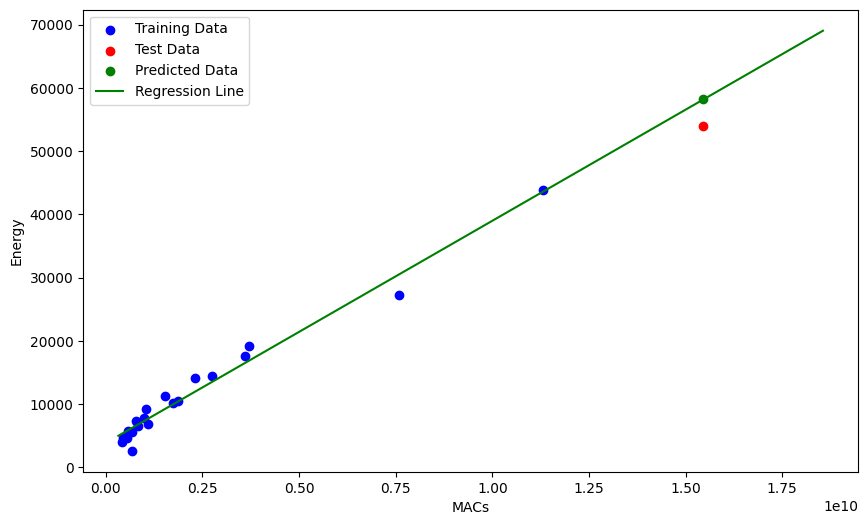

In [22]:
PlotMACs_vs_Energy(modeldata_only16_f, 
                    mac_test_only16_f, 
                        only16_pred_f, 
                 energy_test_only16_f,
                 model_macwithvgg11_f)

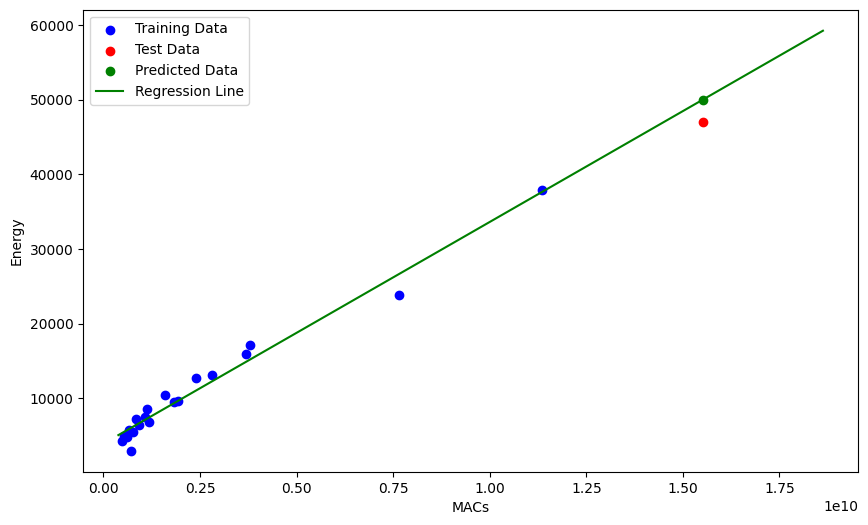

In [23]:
PlotMACs_vs_Energy(modeldata_only16_c, 
                    mac_test_only16_c, 
                        only16_pred_c, 
                 energy_test_only16_c,
                 model_macwithvgg11_c)